In [1]:
from sklearn.metrics import confusion_matrix, classification_report 
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    myMatrix = confusion_matrix(labels, predicted,normalize = 'all')     
    return  errorScore/len(predicted), myMatrix

In [2]:
from tabulate import tabulate
def catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector):
    subIndustryIndex = 0
    counter = -1
    for col in sectorDF.columns: #finding indices for cat variables
        counter += 1
        if col == 'GICS Sub Industry':
            subIndustryIndex = counter
            break
    masterList = sectorDF.values
    catIndicies = [subIndustryIndex]
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)

    trainPools = [Pool(data = masterTrainList, label = zScoreTrainList, cat_features = catIndicies),
    Pool(data = masterTrainList, label = fiveDayChangeTrainList, cat_features = catIndicies)]
    testPools = [Pool(data = masterTestList, label = zScoreTestList, cat_features = catIndicies),
    Pool(data = masterTestList, label = fiveDayChangeTestList, cat_features = catIndicies)]
    modelNames = ['ZScorePredictor','FiveDayPredictor']
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    print('Catboost:')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in sectorDF.columns])
        print(name)
        model = CatBoostClassifier()
        model.fit(train, eval_set = test, logging_level = 'Silent')
        sector = sector.replace(' ', '_')
        model.save_model(folderRoot + name + sector + '.mlmodel')
        accuracy =  model.score(test)
        print('Accuracy: ', accuracy)
        print(CatBoostClassifier.get_feature_importance(model, prettified = True))
        error, matrix = scoreCalculator(model, test,test.get_label())
        print('Error Score:', error)
        print('Confusion matrix:\n', matrix)
        accuracyList.append(accuracy)
        scoreList.append(error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    return averageAccuracy, averageScore

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import json
import os
from tabulate import tabulate

def sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector):

    folderRoot = 'sciKitPredictors/'
    print('\nSci-Kit:')
    sectorDF.drop(columns = ['GICS Sub Industry'], inplace = True)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)
    
    
    hyperParamDict = {'accuracy': 0,
    'error_score': -np.inf,
    'min_samples_split': 5,
    'min_impurity_decrease': 0}
    min_samples_splitChoices = [5,15,20,50,100, 200]
    min_impurity_decreaseChoices = [0, 0.00001,0.0001, 0.001, 0.01, 0.05, 0.1, 0.15]
    trainTestBundles = [['zScore', zScoreTrainList, zScoreTestList, hyperParamDict.copy()],
    ['fiveDay',fiveDayChangeTrainList, fiveDayChangeTestList, hyperParamDict.copy()]]

    for minSplit in min_samples_splitChoices:
        for minImpurity in min_impurity_decreaseChoices:
            for bundle in trainTestBundles:
                errorScoreList = []
                accuracyList = []
                for randState in range(3):
                    predictor = RandomForestClassifier(min_samples_split = minSplit, min_impurity_decrease = minImpurity,
                        random_state = randState, n_jobs = 2)
                    predictor.fit(masterTrainList, bundle[1])
                    predictions = predictor.predict(masterTestList)
                    predictionAccuracy = accuracy_score(bundle[2],predictions)
                    feature = pd.DataFrame(predictor.feature_importances_,
                                                        index = sectorDF.columns,
                                                        columns=['importance']).sort_values('importance', ascending=False)
                    errorScore, _ = scoreCalculator(predictor, masterTestList, zScoreTestList)
                    errorScoreList.append(errorScore)
                    accuracyList.append(predictionAccuracy)
                errorScore = sum(errorScoreList)/len(errorScoreList)
                predictionAccuracy = sum(accuracyList)/len(accuracyList)
                if errorScore > bundle[3]['error_score']:
                    bundle[3]['accuracy'] = predictionAccuracy
                    bundle[3]['error_score'] = errorScore
                    bundle[3]['min_samples_split'] = minSplit
                    bundle[3]['min_impurity_decrease'] = minImpurity
    print('Final result:')
    print(trainTestBundles[0][0], ' ', trainTestBundles[0][3])
    print(trainTestBundles[1][0], ' ',trainTestBundles[1][3])
    for bundle in trainTestBundles:
        print('bundle')
        predictor = RandomForestClassifier(min_samples_split = bundle[3]['min_samples_split'], 
        min_impurity_decrease = bundle[3]['min_impurity_decrease'], random_state = 1, n_jobs = 2)
        predictor.fit(masterTrainList, bundle[1])
        
        headers = ["name", "score"]
        values = sorted(zip(sectorDF.columns, predictor.feature_importances_), key=lambda x: x[1] * -1)
        print(tabulate(values, headers, tablefmt="plain"))
        
        _, matrix = scoreCalculator(predictor, masterTestList, zScoreTestList)
        print(bundle[0], ' confusion matrix\n',matrix)
        sector = sector.replace(' ', '_')
        pickle.dump(predictor, open(folderRoot + bundle[0] + sector + '.pkl', 'wb'))
    averageAccuracy = sum([trainTestBundles[x][3]['accuracy'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    averageScore = sum([trainTestBundles[x][3]['error_score'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    return averageAccuracy, averageScore

VolumeZScoreTenDay
highVsLowPerc
dayPercentChange
fiveVSTenDayWeightedAverage
fiveVsTenDaySlopeChange
fiveVsTenDayAverage
MACD
bPercent
rsi
slowVSFastKAMA
aroon
bop
MFI
WilliamsR
zScoreOfChangeTmmrw
percentChangeInFiveDays
typPrice
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
sent
sentChangeSinceYesterday
bPercentSent
DTWEXAFEGSValue
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEfiveVsTenTickAverage
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATElastChangeP
UNRATEfiveVsTenTickAverage
UNRATEbPercent
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSlastChangeP
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
CCLACBW027SBOGfiveVsTenTickAverage
CCLACBW027SBOGbPercent
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTenTickAverage
STLFSI2bPercent
PRS85006092Value
PRS8

VolumeZScoreTenDay
highVsLowPerc
MACD
bPercent
slowVSFastKAMA
aroon
MFI
zScoreOfChangeTmmrw
percentChangeInFiveDays
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
UNRATEValue
UNRATEfiveVsTenTickAverage
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTenTickAverage
STLFSI2bPercent
PRS85006092Value
PRS85006092lastChangeP
PRS85006092bPercent
TCUValue
TCUlastChangeP
TCUfiveVsTenTickAverage
TCUbPercent
BOPGSTBValue
BOPGSTBlastChangeP
BOPGSTBbPercent
CPIAUCSLValue
CPIAUCSLfiveVsTenTickAverage
CPIAUCSLbPercent
SFTPINDM114SFRBSFValue
SFTPINDM114SFRBSFlastChangeP
SFTPINDM114SFRBSFfiveVsTenTickAverage
SFTPINDM114SFRBSFbPercent
WALC

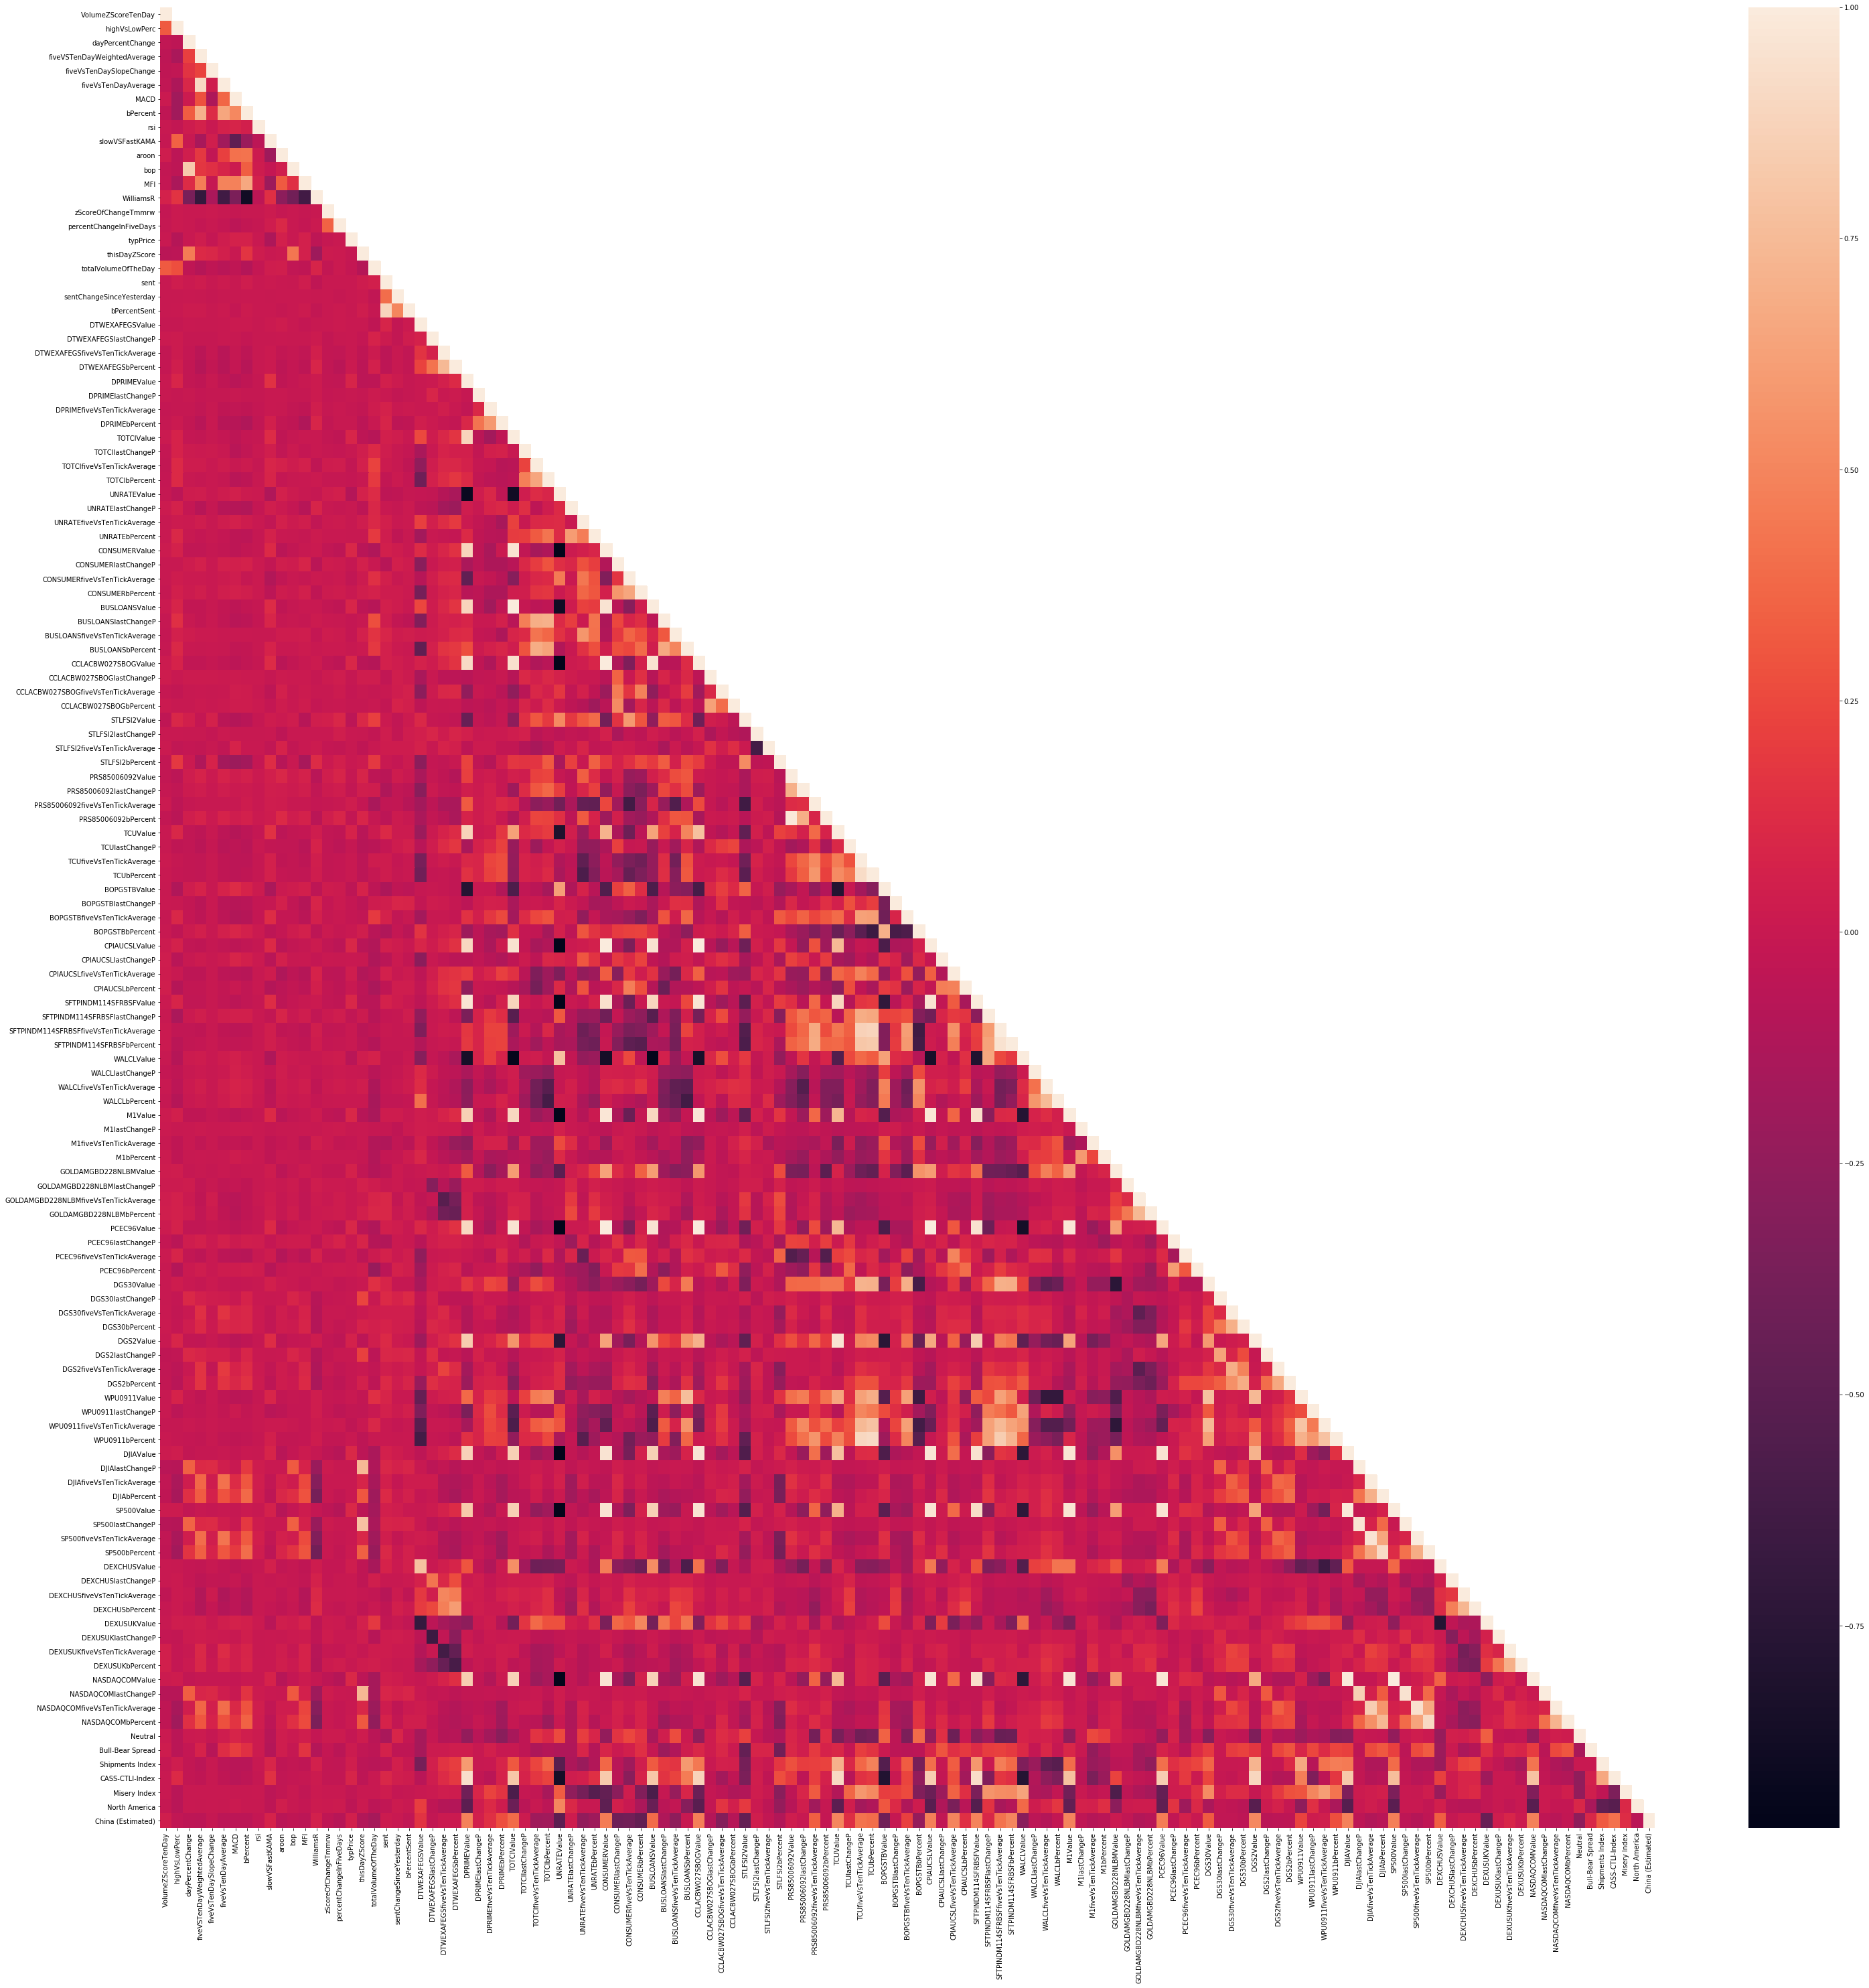

-------------------------------------------


Sector is:  Health Care
Catboost:
ZScorePredictor
Accuracy:  0.6088951425425181
                               Feature Id  Importances
0                          slowVSFastKAMA     3.868315
1                           highVsLowPerc     3.620561
2                      VolumeZScoreTenDay     3.222094
3                      DEXCHUSlastChangeP     2.940889
4                       GICS Sub Industry     2.796547
5                                bPercent     2.580338
6                                     MFI     2.527735
7                     totalVolumeOfTheDay     2.520579
8             GOLDAMGBD228NLBMlastChangeP     2.403245
9                           thisDayZScore     2.346401
10                  DTWEXAFEGSlastChangeP     2.342352
11                     DEXUSUKlastChangeP     2.322751
12                                   MACD     2.222504
13                       DGS30lastChangeP     2.128659
14                                  aroon     2.0

Error Score: 5.912761531873241
Confusion matrix:
 [[0.27095314 0.09219381 0.050104  ]
 [0.09922917 0.21571027 0.01694604]
 [0.08986908 0.02575554 0.13923896]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6055711896896284, 'error_score': 3.3698356376687464, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.5979240588931033, 'error_score': 1.4487744198376769, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
slowVSFastKAMA                         0.0808102
highVsLowPerc                          0.0805805
VolumeZScoreTenDay                     0.0781908
bPercent                               0.0760655
MACD                                   0.0759296
MFI                                    0.0742447
aroon                                  0.0643867
totalVolumeOfTheDay                    0.0131639
GOLDAMGBD228NLBMlastChangeP            0.010976
NASDAQCOMfiveVsTenTickAverage          0.0108894
DJI

fiveDay  confusion matrix
 [[0.25419063 0.16670745 0.09513031]
 [0.09347853 0.11336107 0.0367674 ]
 [0.10369509 0.0554264  0.08124312]]
-------------------------------------------


Sector is:  Industrials
Catboost:
ZScorePredictor
Accuracy:  0.6250128402670776
                               Feature Id  Importances
0                           highVsLowPerc     3.318340
1                          slowVSFastKAMA     3.277281
2             GOLDAMGBD228NLBMlastChangeP     2.734087
3                      DEXUSUKlastChangeP     2.706112
4                                    MACD     2.647471
5                     totalVolumeOfTheDay     2.647179
6                      VolumeZScoreTenDay     2.616292
7                         DGS2lastChangeP     2.609228
8                                     MFI     2.529300
9                       GICS Sub Industry     2.485711
10                  DTWEXAFEGSlastChangeP     2.467001
11                       DGS30lastChangeP     2.453443
12                     

Error Score: 6.1743708269132
Confusion matrix:
 [[0.28500257 0.0788906  0.05274782]
 [0.11088855 0.21052902 0.01109399]
 [0.09388803 0.01597329 0.14098613]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6125834617360041, 'error_score': 3.288135593220339, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6181133367574045, 'error_score': 1.2996062318096215, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0954336
slowVSFastKAMA                         0.0913872
bPercent                               0.0891358
MACD                                   0.0883752
VolumeZScoreTenDay                     0.0882554
MFI                                    0.0875597
aroon                                  0.0749684
totalVolumeOfTheDay                    0.0103875
NASDAQCOMfiveVsTenTickAverage          0.00927302
DJIAlastChangeP                        0.00870088
DEXUSUKlas

fiveDay  confusion matrix
 [[0.28361582 0.15649718 0.09219312]
 [0.101849   0.10190036 0.03276836]
 [0.1058038  0.05187468 0.07349769]]
-------------------------------------------


Sector is:  Consumer Discretionary
Catboost:
ZScorePredictor
Accuracy:  0.5838061785103126
                               Feature Id  Importances
0                          slowVSFastKAMA     4.498053
1                           highVsLowPerc     3.960232
2                      VolumeZScoreTenDay     3.301466
3                                    MACD     3.046719
4                     totalVolumeOfTheDay     2.909384
5                                bPercent     2.891166
6                       GICS Sub Industry     2.866590
7             GOLDAMGBD228NLBMlastChangeP     2.711831
8                                     MFI     2.623213
9                        DGS30lastChangeP     2.483667
10                     DEXCHUSlastChangeP     2.428543
11                          thisDayZScore     2.247371
12          

Error Score: 6.243132486715302
Confusion matrix:
 [[0.20656579 0.0878141  0.07227776]
 [0.09803657 0.2120598  0.0257588 ]
 [0.09474917 0.03138791 0.17135009]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.5787174637485365, 'error_score': 2.8227355969857997, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5577021225494612, 'error_score': 1.1485634513194631, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0995227
slowVSFastKAMA                         0.0981873
VolumeZScoreTenDay                     0.0938428
MACD                                   0.09331
bPercent                               0.0933031
MFI                                    0.0917111
aroon                                  0.0822778
totalVolumeOfTheDay                    0.00931102
GOLDAMGBD228NLBMlastChangeP            0.00804562
DGS30lastChangeP                       0.00803872
DJIAl

fiveDay  confusion matrix
 [[0.22165181 0.16774746 0.13401783]
 [0.08335585 0.11204179 0.05097721]
 [0.08362605 0.06201027 0.08457174]]
-------------------------------------------


Sector is:  Information Technology
Catboost:
ZScorePredictor
Accuracy:  0.6310588495086673
                               Feature Id  Importances
0                           highVsLowPerc     3.439771
1                          slowVSFastKAMA     3.182838
2                      DEXCHUSlastChangeP     2.792631
3                      VolumeZScoreTenDay     2.785695
4                        DGS30lastChangeP     2.774635
5                     totalVolumeOfTheDay     2.709682
6                           thisDayZScore     2.669695
7                                bPercent     2.619582
8             GOLDAMGBD228NLBMlastChangeP     2.468656
9                                    MACD     2.367640
10                                    MFI     2.313205
11                   NASDAQCOMlastChangeP     2.290903
12          

Error Score: 6.516782599094623
Confusion matrix:
 [[0.25477531 0.09655515 0.04709065]
 [0.10130286 0.24677045 0.0140223 ]
 [0.08225682 0.02285525 0.1343712 ]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.623918884104376, 'error_score': 3.669997423723823, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6092893158146553, 'error_score': 1.4880755216959258, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0935353
slowVSFastKAMA                         0.0886462
bPercent                               0.0883813
VolumeZScoreTenDay                     0.0877531
MACD                                   0.0868042
MFI                                    0.0856624
aroon                                  0.0739454
totalVolumeOfTheDay                    0.0128238
NASDAQCOMfiveVsTenTickAverage          0.0105109
SP500bPercent                          0.00958611
NASDAQCOMbP

fiveDay  confusion matrix
 [[0.25046925 0.1846638  0.0904825 ]
 [0.08579    0.12321961 0.03417246]
 [0.09478856 0.06100254 0.07541128]]
-------------------------------------------


Sector is:  Consumer Staples
Catboost:
ZScorePredictor
Accuracy:  0.6044158233670653
                               Feature Id  Importances
0                           highVsLowPerc     3.478893
1                          slowVSFastKAMA     3.463328
2                      VolumeZScoreTenDay     3.153311
3                     totalVolumeOfTheDay     3.005435
4                                bPercent     2.742442
5                       GICS Sub Industry     2.661378
6             GOLDAMGBD228NLBMlastChangeP     2.645919
7                      DEXCHUSlastChangeP     2.513967
8                        DGS30lastChangeP     2.460090
9                         DGS2lastChangeP     2.441393
10                                   MACD     2.402763
11                                    MFI     2.272969
12                


Sci-Kit:
Final result:
zScore   {'accuracy': 0.602814405942281, 'error_score': 3.00350948925006, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6000885890490307, 'error_score': 1.0199666087430577, 'min_samples_split': 20, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0780596
VolumeZScoreTenDay                     0.0748654
slowVSFastKAMA                         0.0746465
MACD                                   0.0727731
bPercent                               0.0722666
MFI                                    0.0709998
aroon                                  0.0637935
NASDAQCOMfiveVsTenTickAverage          0.0124337
totalVolumeOfTheDay                    0.0121104
DJIAlastChangeP                        0.0115362
SP500lastChangeP                       0.0115206
DGS30lastChangeP                       0.0112009
thisDayZScore                          0.0109913
DEXUSUKlastChangeP  

-------------------------------------------


Sector is:  Utilities
Catboost:
ZScorePredictor
Accuracy:  0.7161376302398836
                               Feature Id  Importances
0                           highVsLowPerc     3.344603
1                      DEXUSUKlastChangeP     3.276065
2                          slowVSFastKAMA     3.267736
3                     totalVolumeOfTheDay     3.083001
4             GOLDAMGBD228NLBMlastChangeP     3.075045
5                      VolumeZScoreTenDay     2.747168
6                           thisDayZScore     2.628995
7                      DEXCHUSlastChangeP     2.625969
8                   DTWEXAFEGSlastChangeP     2.499461
9                         DJIAlastChangeP     2.368493
10                               bPercent     2.313320
11                                    MFI     2.311610
12                                   MACD     2.298175
13                   NASDAQCOMlastChangeP     2.164875
14                        DGS2lastChangeP     2.163


Sci-Kit:
Final result:
zScore   {'accuracy': 0.7129876423552216, 'error_score': 5.084201599224618, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.7195299248849043, 'error_score': 1.650512882642759, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0687439
slowVSFastKAMA                         0.067121
bPercent                               0.0654778
MACD                                   0.0652964
MFI                                    0.0612615
VolumeZScoreTenDay                     0.0611824
aroon                                  0.0502397
totalVolumeOfTheDay                    0.0175583
DEXUSUKlastChangeP                     0.0143808
thisDayZScore                          0.0143474
GOLDAMGBD228NLBMlastChangeP            0.0139409
DJIAlastChangeP                        0.0132892
DGS2lastChangeP                        0.0129066
DTWEXAFEGSlastChangeP   

-------------------------------------------


Sector is:  Financials
Catboost:
ZScorePredictor
Accuracy:  0.6782853919909757
                               Feature Id  Importances
0                     totalVolumeOfTheDay     3.154300
1                           highVsLowPerc     3.095843
2             GOLDAMGBD228NLBMlastChangeP     3.040456
3                          slowVSFastKAMA     3.038169
4                         DGS2lastChangeP     2.634137
5                      DEXCHUSlastChangeP     2.591268
6                        DGS30lastChangeP     2.555409
7                                    MACD     2.519379
8                      VolumeZScoreTenDay     2.376949
9                    NASDAQCOMlastChangeP     2.332459
10                  DTWEXAFEGSlastChangeP     2.308509
11                      GICS Sub Industry     2.256760
12                     DEXUSUKlastChangeP     2.215916
13                           DJIAbPercent     2.214339
14                          thisDayZScore     2.10

Error Score: 6.707275803722505
Confusion matrix:
 [[0.3287084  0.06976875 0.04545967]
 [0.0929498  0.21940214 0.00620417]
 [0.08319233 0.00840384 0.14591089]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6751833051325438, 'error_score': 4.484395563075766, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.671329197217522, 'error_score': 1.5550855423951873, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0876144
slowVSFastKAMA                         0.0865691
MACD                                   0.0847609
bPercent                               0.0839031
MFI                                    0.0822672
VolumeZScoreTenDay                     0.0816722
aroon                                  0.0676089
DJIAbPercent                           0.0117446
totalVolumeOfTheDay                    0.0112571
SP500bPercent                          0.010613
NASDAQCOMfive

fiveDay  confusion matrix
 [[0.2822335  0.15279188 0.10208686]
 [0.10022561 0.10812183 0.03079526]
 [0.1037225  0.0464749  0.07354766]]
-------------------------------------------


Sector is:  Real Estate
Catboost:
ZScorePredictor
Accuracy:  0.6594269265995029
                               Feature Id  Importances
0                          slowVSFastKAMA     3.946604
1                           highVsLowPerc     3.763239
2                      VolumeZScoreTenDay     3.310870
3                   DTWEXAFEGSlastChangeP     3.289652
4                     totalVolumeOfTheDay     3.124080
5                      DEXCHUSlastChangeP     3.111631
6             GOLDAMGBD228NLBMlastChangeP     3.057043
7                                     MFI     2.956186
8                                bPercent     2.902437
9                                    MACD     2.835700
10                     DEXUSUKlastChangeP     2.569952
11                                  aroon     2.486769
12                     


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6561123468097169, 'error_score': 4.303065986305552, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6480875746870775, 'error_score': 1.5672292729730908, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0653581
slowVSFastKAMA                         0.0627245
bPercent                               0.0605878
VolumeZScoreTenDay                     0.0599916
MACD                                   0.0598098
MFI                                    0.0582754
aroon                                  0.0516463
totalVolumeOfTheDay                    0.0167832
DJIAlastChangeP                        0.0137897
GOLDAMGBD228NLBMlastChangeP            0.0135442
DEXUSUKlastChangeP                     0.0135083
DEXCHUSlastChangeP                     0.0133473
DEXCHUSbPercent                        0.0131728
DGS30lastChange

-------------------------------------------


Sector is:  Materials
Catboost:
ZScorePredictor
Accuracy:  0.5999394306480921
                               Feature Id  Importances
0                           highVsLowPerc     3.909010
1                      VolumeZScoreTenDay     3.520005
2                          slowVSFastKAMA     3.346169
3                                     MFI     3.011624
4             GOLDAMGBD228NLBMlastChangeP     2.830701
5                         DGS2lastChangeP     2.790604
6                      DEXCHUSlastChangeP     2.787730
7                                bPercent     2.731359
8                     totalVolumeOfTheDay     2.651265
9                                    MACD     2.621588
10                       DGS30lastChangeP     2.614887
11                     DEXUSUKlastChangeP     2.480647
12                      GICS Sub Industry     2.390606
13                  DTWEXAFEGSlastChangeP     2.244501
14                                  aroon     2.114


Sci-Kit:
Final result:
zScore   {'accuracy': 0.5949424591156874, 'error_score': 3.127649909145972, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.5875227135069655, 'error_score': 0.9892994144962648, 'min_samples_split': 20, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0683826
slowVSFastKAMA                         0.0642921
VolumeZScoreTenDay                     0.0629659
bPercent                               0.0623861
MFI                                    0.0615458
MACD                                   0.0614605
aroon                                  0.0529313
totalVolumeOfTheDay                    0.0144183
DGS30lastChangeP                       0.0133534
NASDAQCOMfiveVsTenTickAverage          0.0132464
DTWEXAFEGSlastChangeP                  0.0130692
DEXUSUKbPercent                        0.0128925
DJIAbPercent                           0.0127631
DEXUSUKlastCha

Catboost:
ZScorePredictor
Accuracy:  0.6409880678249947
                               Feature Id  Importances
0                           highVsLowPerc     3.666595
1                          slowVSFastKAMA     3.588498
2                           thisDayZScore     3.092347
3             GOLDAMGBD228NLBMlastChangeP     3.089434
4                      VolumeZScoreTenDay     3.063028
5                     totalVolumeOfTheDay     2.965199
6                      DEXUSUKlastChangeP     2.817094
7                                bPercent     2.750427
8                        DGS30lastChangeP     2.582031
9                         DGS2lastChangeP     2.550053
10                                    MFI     2.535704
11                  DTWEXAFEGSlastChangeP     2.446147
12                                   MACD     2.378110
13                     DEXCHUSlastChangeP     2.037959
14                   NASDAQCOMlastChangeP     1.940837
15                      GICS Sub Industry     1.929911
16       


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6472681599330122, 'error_score': 4.439327332356431, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6290907822203615, 'error_score': 2.012420626613635, 'min_samples_split': 20, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0710901
slowVSFastKAMA                         0.0700294
MACD                                   0.0666203
VolumeZScoreTenDay                     0.066466
bPercent                               0.0658656
MFI                                    0.0637033
aroon                                  0.0543767
thisDayZScore                          0.0141516
totalVolumeOfTheDay                    0.0139565
DEXUSUKlastChangeP                     0.0135012
GOLDAMGBD228NLBMlastChangeP            0.0133909
DGS2lastChangeP                        0.0132786
DEXCHUSlastChangeP                     0.01253
DJIAlastChangeP       

-------------------------------------------


Sector is:  Telecommunications Services
Catboost:
ZScorePredictor
Accuracy:  0.5968928863450531
                               Feature Id  Importances
0                           highVsLowPerc     5.199908
1                      VolumeZScoreTenDay     3.972593
2                          slowVSFastKAMA     3.612907
3                                bPercent     3.244228
4                                    MACD     3.206412
5                           thisDayZScore     3.155827
6                                   aroon     2.941446
7                     totalVolumeOfTheDay     2.448204
8                                     MFI     2.420495
9                         DJIAlastChangeP     2.402508
10            GOLDAMGBD228NLBMlastChangeP     2.300253
11                     DEXCHUSlastChangeP     2.221272
12                  DTWEXAFEGSlastChangeP     2.115484
13                     DEXUSUKlastChangeP     2.034277
14                       TOTCIlas

Final result:
zScore   {'accuracy': 0.6009811937857727, 'error_score': 1.3464159171436358, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6385936222403924, 'error_score': 1.0452439356772965, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
slowVSFastKAMA                         0.0395679
highVsLowPerc                          0.0389832
VolumeZScoreTenDay                     0.033537
bPercent                               0.0328776
MFI                                    0.0308529
MACD                                   0.0306302
aroon                                  0.0271304
thisDayZScore                          0.0201374
totalVolumeOfTheDay                    0.0189786
DJIAlastChangeP                        0.0185272
GOLDAMGBD228NLBMlastChangeP            0.0182642
DEXUSUKlastChangeP                     0.0180367
DEXCHUSlastChangeP                     0.0177504
DGS30lastChangeP            

In [4]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)


combinedDF = pd.read_csv('data/masterDF.csv', parse_dates = True)
combinedDF.drop(columns=['tmmrwChngAsPerc', 'Date', 'thisDayAveragePercentChange', 'thisDayPercentChangeStdev',
        'fiveDayWeightedAverage', 'tenDayWeightedAverage', 'fiveDaySlopeChange', 'tenDaySlopeChange', 
        'ticker', 'High', 'Low', 'Open', 'Close', 'Volume', 'fiveDayAverage', 'tenDayAverage', 'averageUp', 'averageDown'], inplace = True)
combinedDF.dropna(inplace = True)
for col in combinedDF.columns:
    print(col)
myBasicCorr = combinedDF.corr()
print('zScoreOfChangeTmmrw correlation: \n')
print(myBasicCorr['zScoreOfChangeTmmrw'].sort_values())
print('percentChangeInFiveDays correlation: \n')
print(myBasicCorr['percentChangeInFiveDays'].sort_values())
combinedCorr = (myBasicCorr['zScoreOfChangeTmmrw'].abs() + myBasicCorr['percentChangeInFiveDays'].abs())
print('combinedCorr: \n')
print(combinedCorr.sort_values())
correlationRequirement = .02
toDrop = combinedCorr[combinedCorr < correlationRequirement].index
print(toDrop)
combinedDF.drop(columns = toDrop, inplace = True)
for col in combinedDF.columns:
    print(col)
plt.subplots(figsize=(50,50))
myBasicCorr = myBasicCorr.where(np.tril(np.ones(myBasicCorr.shape)).astype(np.bool))
sns.heatmap(myBasicCorr)
plt.show()

print('-------------------------------------------\n\n')
sectorList = combinedDF['GICS Sector'].copy().unique()
catAccuracy = []
catError = []
scikitAccuracy = []
scikitError = []
for sector in sectorList:
    print('Sector is: ', sector)
    sectorDF = combinedDF[combinedDF['GICS Sector'] == sector].copy()
    zScoreAnswer = sectorDF['zScoreOfChangeTmmrw']
    zScoreAnswer = zScoreAnswer.astype('float')
    zScoreAnswer = ['long' if x > .5 else 'short' if x < -.5 else 'hold' for x in zScoreAnswer ]
    fiveDayChangeAnswer = sectorDF['percentChangeInFiveDays']
    fiveDayChangeAnswer = ['long' if x > .015 else 'short' if x < -.015 else 'hold' for x in fiveDayChangeAnswer]
    
    sectorDF.drop(columns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'GICS Sector'], inplace = True)
    accuracy, error = catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector)
    catAccuracy.append(accuracy)
    catError.append(error)
    
    accuracy, error = sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector)
    scikitAccuracy.append(accuracy)
    scikitError.append(error)
    print('-------------------------------------------\n\n')
print('Catboost accuracy: ', mean(catAccuracy))
print('Catboost score: ' ,mean(catError))
print('Sci-kit accuracy: ', mean(scikitAccuracy))
print('Sci-kit score: ', mean(scikitError))